In [23]:
from transformers import AutoImageProcessor, ViTForImageClassification
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [24]:
model_name = "google/vit-base-patch16-224"

image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

cuda


In [25]:
def mask_patches(inputs, mask_fraction=0.3):
    pixel_values = inputs["pixel_values"]
    B, C, H, W = pixel_values.shape
    patch_size = 16
    num_patches = (H // patch_size) * (W // patch_size)
    patches_per_side = H // patch_size
    patches = pixel_values.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, num_patches, patch_size, patch_size)

    num_to_mask = int(mask_fraction * num_patches)
    for b in range(B):
        mask_indices = random.sample(range(num_patches), num_to_mask)
        patches[b, :, mask_indices] = 0.0  # set to black
    
    patches = patches.view(B, C, patches_per_side, patches_per_side, patch_size, patch_size)
    patches = patches.permute(0, 1, 2, 4, 3, 5).contiguous()
    masked_pixel_values = patches.view(B, C, H, W)
    
    return {"pixel_values": masked_pixel_values}

In [26]:
img_paths = [
    "img/bicycle-built-for-two.jpg",
    "img/rubber_eraser.jpg",
    "img/seat_belt.jpg",
    "img/space_shuttle.jpg",
    "img/vacuum.jpg"
]

images = [Image.open(path).convert("RGB") for path in img_paths]
inputs = image_processor(images=images, return_tensors="pt")
masked_inputs = mask_patches(inputs, mask_fraction=0.3)

In [27]:
model.eval()
with torch.no_grad():
    outputs = model(**masked_inputs)
    attentions = outputs.attentions
    logits = outputs.logits

predicted_ids = logits.argmax(dim=1).tolist()
labels = model.config.id2label
for i, pred in enumerate(predicted_ids):
    print(f"Image {i+1}: {labels[pred]}")

Image 1: bicycle-built-for-two, tandem bicycle, tandem
Image 2: rubber eraser, rubber, pencil eraser
Image 3: seat belt, seatbelt
Image 4: space shuttle
Image 5: vacuum, vacuum cleaner


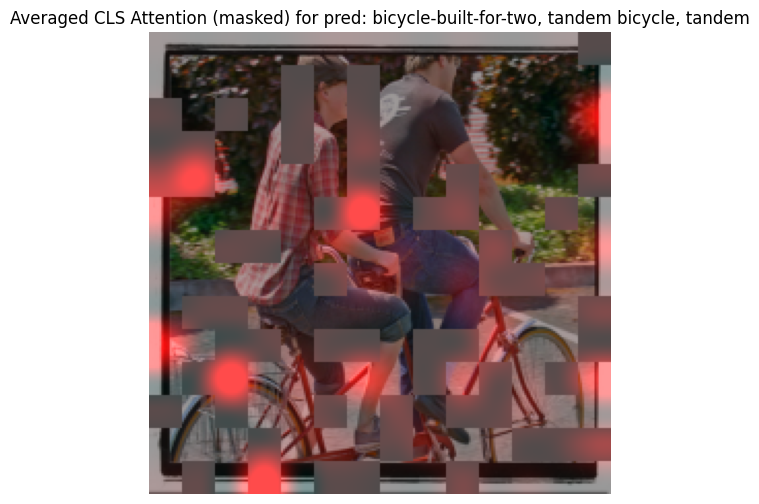

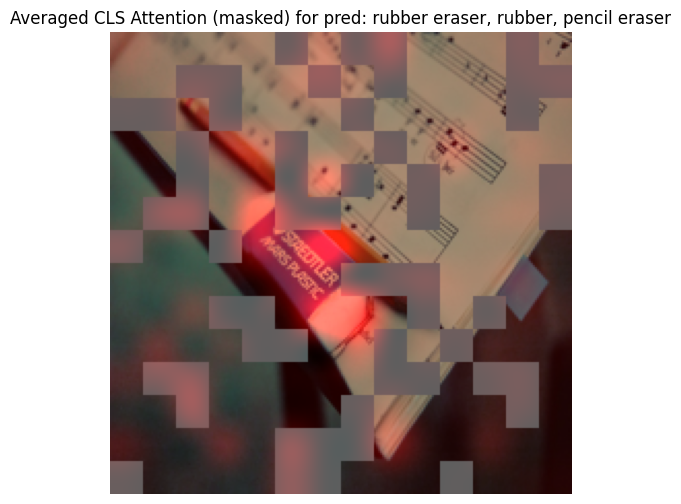

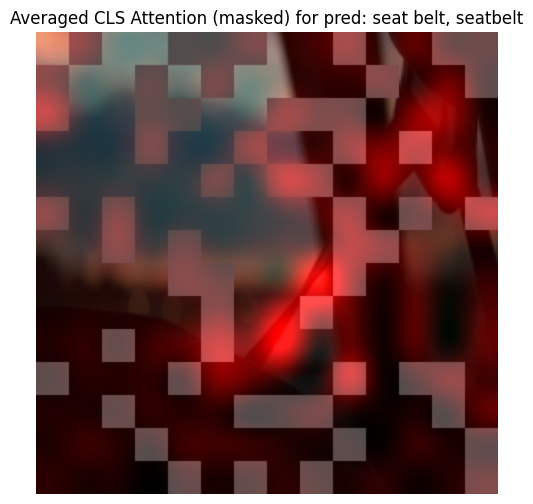

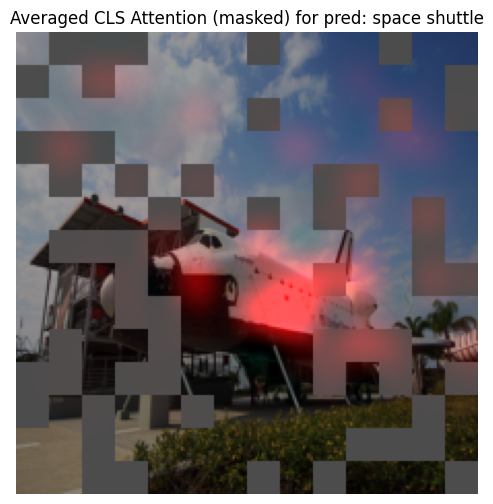

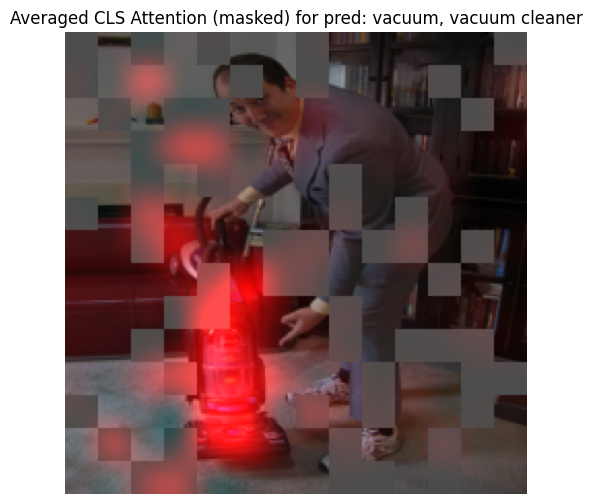

In [28]:
for idx, img in enumerate(images):
    cls_attn = attentions[-1][idx]
    cls_attn = cls_attn.mean(dim=0)
    cls_attn_vector = cls_attn[0, 1:]
    attn_map = cls_attn_vector.reshape(14, 14).cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    attn_map_resized = cv2.resize(attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)

    masked_img_tensor = masked_inputs["pixel_values"][idx].cpu()
    masked_img_np = masked_img_tensor.permute(1, 2, 0).numpy()
    masked_img_np = (masked_img_np - masked_img_np.min()) / (masked_img_np.max() - masked_img_np.min())

    heatmap = np.zeros_like(masked_img_np)
    heatmap[:, :, 0] = attn_map_resized
    
    overlay = 0.6 * masked_img_np + heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Averaged CLS Attention (masked) for pred: {labels[predicted_ids[idx]]}")
    plt.show()
